# Spatial relationships and operations
**based on scipy2018-geospatial**

## goals of the tutorial
- load tabular data files (eg. csv or xls) as geodataframe
- spatial projection conversion
- spatial relationships
- spatial joins
- spatial operations

**based on the open data of:**
- [ISTAT](https://www.istat.it/it/archivio/222527) Italian National Institute of Statistic
- [Italian Ministry of Environment and Energy Security](https://www.mase.gov.it/)


### requirements
- python knowledge
- pandas
- previous lesson

### status
*"Spatial is Special"*

---

# SETUP

In [1]:
pip install -r https://napo.github.io/geospatialcourse2025/requirements.txt --break-system-packages

## Import

In [2]:
import pandas as pd
import geopandas as gpd
import requests
import matplotlib.pyplot as plt #to avoid the warning message by plotting the geometries
import warnings
warnings.simplefilter("ignore")

# data setup
## administrative units of italy

geopackage with the administrative units of italy

The couse offers the file in a geopackage stored [here](https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/istat_administrative_units_generalized_2024.gpkg)

In [3]:
url = 'https://github.com/napo/geospatialcourse2025/raw/refs/heads/main/data/istat_administrative_units_generalized_2025.gpkg'

In [4]:
macroregions = gpd.read_file(url,layer="macroregions")

you can repeat the operation ( = direct download) for each layer but it's better to download the file once and load the layers step by step.

In [5]:
# download the file
geopackage_istat_file = "istat_administrative_units_2025.gpkg"
r = requests.get(url, allow_redirects=True)
open(geopackage_istat_file, 'wb').write(r.content)

21172224

In [6]:
regions = gpd.read_file(geopackage_istat_file,layer="regions")

In [7]:
provinces = gpd.read_file(geopackage_istat_file,layer="provinces")

In [8]:
municipalities = gpd.read_file(geopackage_istat_file,layer="municipalities")

In [9]:
macroregions

COD_RIP     DEN_RIP                                           geometry
0        1  Nord-ovest  MULTIPOLYGON (((568231.969 4874857.994, 568233...
1        2    Nord-est  MULTIPOLYGON (((618335.21 4893983.16, 618329.9...
2        3      Centro  MULTIPOLYGON (((876027.96 4525207.198, 876222....
3        4         Sud  MULTIPOLYGON (((1083304.797 4416671.21, 108333...
4        5       Isole  MULTIPOLYGON (((822779.053 3935557.494, 822909...

## List of electric charging stations in Italy
The Ministry of Environment and Energy Security offers a dataset with a list of charging stations for electric vehicles.

Visit this [page](https://www.piattaformaunicanazionale.it/idr)

The dataset as of October 30, 2025 is available [here](https://github.com/napo/geospatialcourse2025/raw/refs/heads/main/data/italian_charging_stations.csv)<br/>
(Alternatively, simply follow the download link on the website https://www.piattaformaunicanazionale.it/idr => Map => List => Export Data)



In [10]:
charging_stations_url = 'https://github.com/napo/geospatialcourse2025/raw/refs/heads/main/data/italian_charging_stations.csv'
charging_stations = pd.read_csv(charging_stations_url,sep=';')

### investigate the data

In [11]:
charging_stations.shape[0]

62978

In [12]:
charging_stations.head(5)

ID EVSE Codice Nazione Provincia    Citta'  \
0        0            ITA      Roma      Roma   
1        1            ITA   Perugia  Corciano   
2        2            ITA    Torino  Chivasso   
3        3            ITA   Brescia   Brescia   
4        4            ITA     Prato    Vaiano   

                                      Indirizzo  Codice postale  Latitudine  \
0  Via della Mendola, 276, 00135 Roma RM, Italy           135.0   41.945138   
1                           Via Aldo Capitini 8          6073.0   43.100029   
2                                 Via Impastato         10034.0   45.201896   
3                       Piazza della Repubblica         25126.0   45.534861   
4                             Piazza del Comune         59021.0   43.968571   

   Longitudine       Stato Tipologia parcheggio  \
0    12.442959      Attivo                        
1    12.307769  Non Attivo                        
2     7.893992      Attivo          PARKING_LOT   
3    10.208505      Attivo                        
4    11.123520      Attivo          PARKING_LOT   

                          ID Connettore Potenza Erogabile  \
0                                     1             Quick   
1                                     1             Quick   
2                                     4              Slow   
3  fe66aa59-75dd-4457-b65a-eaee9f543bd0        Ultra fast   
4                             808897018             Quick   

  Restrizioni parcheggio Servizi nelle vicinanze Orario d'apertura  
0                                                      Aperto 24/7  
1                                                      Aperto 24/7  
2            MOTORCYCLES                               Aperto 24/7  
3                                                      Aperto 24/7  
4                EV_ONLY                               Aperto 24/7

In [13]:
# rename some columns
columns= {
   'Codice Nazione': 'country_code',
   'ID EVSE':'evse_id',
   "Provincia": "province",
   "Citta'": 'municipality',
   'Indirizzo': 'address',
   'Codice postale':'zipcode',
   'Latitudine':'latitude',
   'Longitudine':'longitude',
   'Stato':'status',
   "Tipologia parcheggio":'parking_type',
   'ID Connettore':'connector_id',
   'Potenza Erogabile': 'power',
   'Restrizioni parcheggio':'parking_restrictions',
   'Servizi nelle vicinanze':'nearby_services',
   "Orario d'apertura":'opening_hours'
  }


In [14]:
charging_stations.rename(columns=columns,inplace=True)

In [15]:
charging_stations.country_code.unique()

array(['ITA', 'CHE', 'ETH', 'RUS', 'FRA', 'Italia'], dtype=object)

- ITA => Italy
- CHE => Swiss
- ETH => Ethiopia
- RUS => Russia
- FRA => France
- Italia => Italy

In [16]:
charging_stations.province.unique()

array(['Roma', 'Perugia', 'Torino', 'Brescia', 'Prato', 'Mantova',
       'Genova', 'Siracusa', 'Bari', 'Venezia', 'Napoli', 'Aosta',
       'Pavia', 'Trento', 'Modena', 'Bologna', 'Treviso', 'Forlì-Cesena',
       'Como', 'Parma', 'Rimini', 'Firenze', 'Alessandria', 'Savona',
       'Livorno', 'Milano', 'Padova', 'Udine', 'Florence', 'Bergamo',
       'Foggia', 'Fermo', 'Terni', 'Salerno', 'La Spezia', 'Agrigento',
       'Cuneo', 'Catania', 'Imperia', 'Caserta', 'Cosenza', 'Enna',
       'Lodi', 'Asti', 'Rome', 'Nuoro', 'Grosseto', 'Viterbo',
       'Catanzaro', 'Bolzano', 'Sassari', 'Pordenone', 'Potenza',
       "L'Aquila", 'Massa-Carrara', 'Varese', 'Cremona', 'Arezzo',
       'Reggio di Calabria', 'Crotone', 'Sondrio', "Reggio nell'Emilia",
       'Lecco', 'Vicenza', 'Vibo Valentia', 'Ragusa', 'Cagliari',
       'Messina', 'Piacenza', 'Pisa', 'Milan', 'Novara', 'Verona',
       'Verbano-Cusio-Ossola', 'Avellino', 'Macerata', 'Palermo', 'Siena',
       'Sud Sardegna', 'Belluno', '

### geodataframe creation from the dataframe with x (longitude) and y (latitude)

GeoDataFrame [constructor](https://geopandas.org/reference/geopandas.GeoDataFrame.html):
* a dataframe (or dictionary)
* the CRS
* a geometry field expressed in WKT (eg. POINT (1,3))



now we are ready to create the geodataframe.
the operation are:
- creation of a geometry column based on the WKT syntax
- transform the DataFrame in GeoDataFrame

In [17]:
geo_charging_stations = gpd.GeoDataFrame(
    charging_stations,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(charging_stations.longitude, charging_stations.latitude))

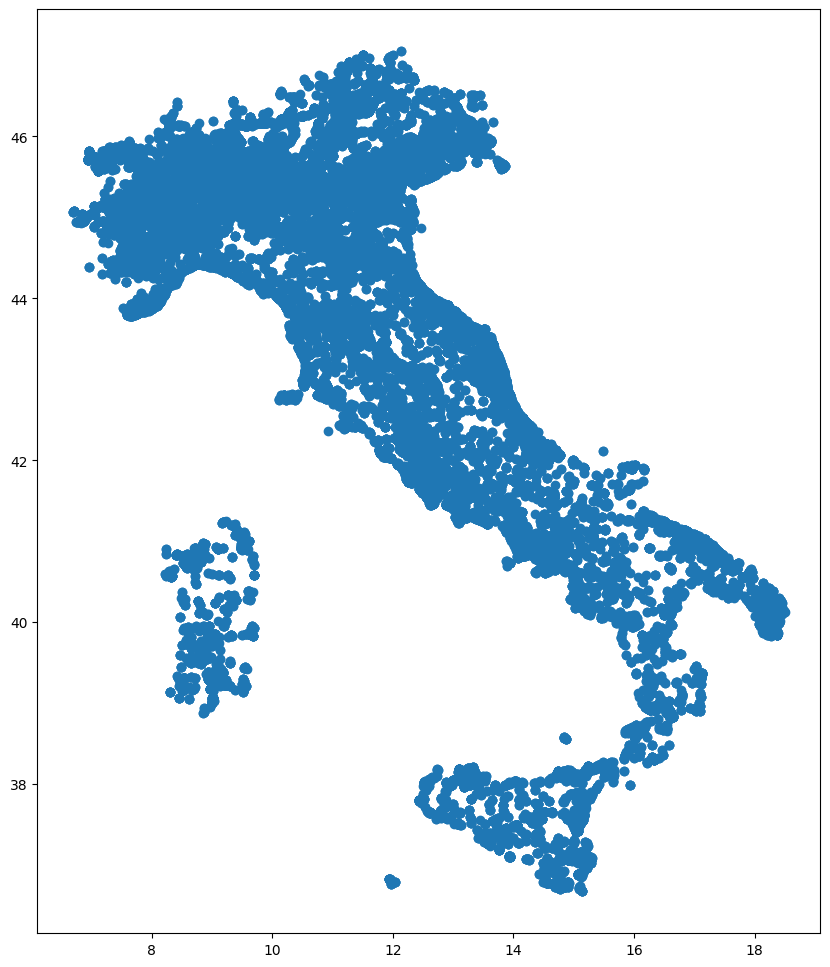

In [18]:
geo_charging_stations.plot(figsize=(12,12))
plt.show()

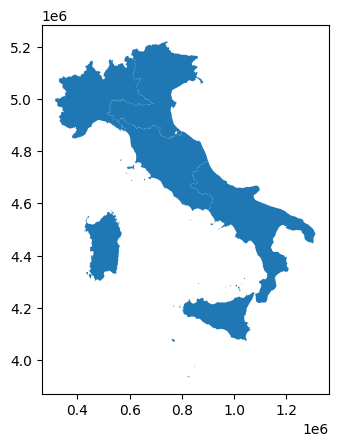

In [19]:
macroregions.plot()
plt.show()

overlay the layers

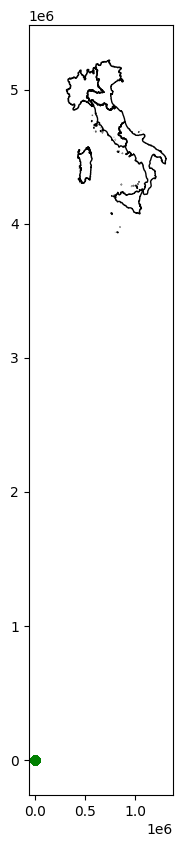

In [20]:
ax = macroregions.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
geo_charging_stations.plot(ax=ax,color="green")
plt.show()

**ERROR**!<br/>
We need to use the same projection!!!<br/>
The projection used in our geodataframe of ISTAT is EPSG:32632

In [21]:
macroregions.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

overlay the layers by using the same projection

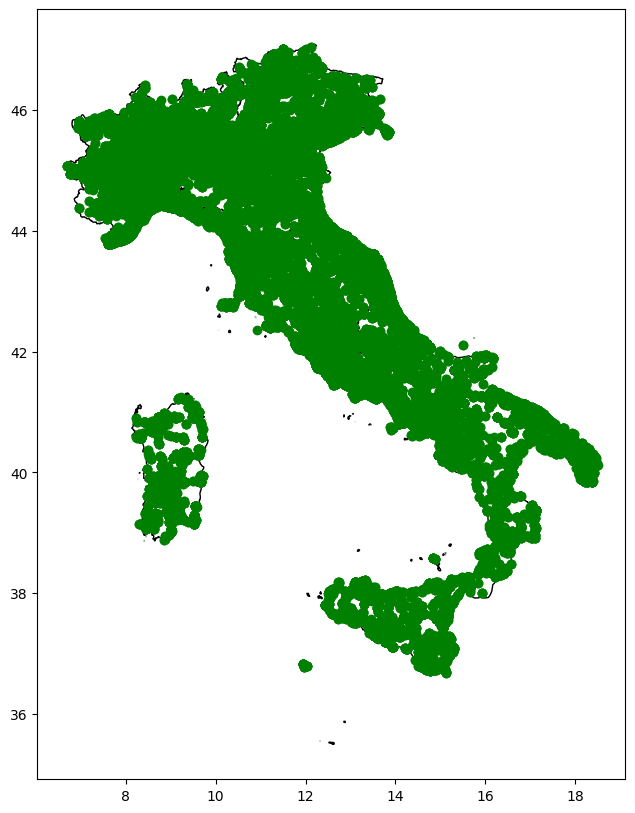

In [22]:
ax = macroregions.to_crs(epsg=4326).plot(edgecolor='k', facecolor='none', figsize=(15, 10))
geo_charging_stations.plot(ax=ax,color="green")
plt.show()

---
# Spatial relationships
## how two spatial objects relate to each other

![](https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png)

from [https://en.wikipedia.org/wiki/Spatial_relation](https://en.wikipedia.org/wiki/Spatial_relation)

## Relationships between individual objects

Eg.<br>
Is this library located in the north-east Italian macro-region?

we need the north-east italian macro-region in wgs84

In [23]:
macroregions

COD_RIP     DEN_RIP                                           geometry
0        1  Nord-ovest  MULTIPOLYGON (((568231.969 4874857.994, 568233...
1        2    Nord-est  MULTIPOLYGON (((618335.21 4893983.16, 618329.9...
2        3      Centro  MULTIPOLYGON (((876027.96 4525207.198, 876222....
3        4         Sud  MULTIPOLYGON (((1083304.797 4416671.21, 108333...
4        5       Isole  MULTIPOLYGON (((822779.053 3935557.494, 822909...

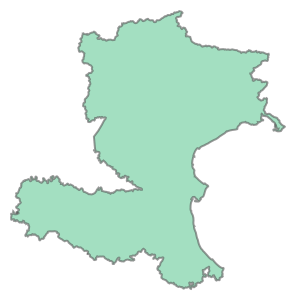

In [24]:
macroregions.geometry[1]

In [25]:
northeast = macroregions.to_crs(epsg=4326).geometry[1]

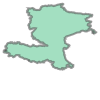

In [26]:
northeast

## let's start with just one point



so we will choose a library in Trento (north east italy)

In [27]:
geo_charging_stations[geo_charging_stations.province == 'Trento'].head(5)

evse_id country_code province                       municipality  \
15        15          ITA   Trento  Primiero San Martino di Castrozza   
56        56          ITA   Trento                       Commezzadura   
336      336          ITA   Trento                      Ronzo-Chienis   
342      342          ITA   Trento                      Ronzo-Chienis   
350      350          ITA   Trento                            Molveno   

                 address  zipcode   latitude  longitude  status parking_type  \
15   Via Passo Rolle 233  38054.0  46.263800  11.801300  Attivo                
56   Via della Fantoma 8  38020.0  46.319400  10.841600  Attivo                
336     Via Trento, 19/D  38060.0  45.889500  10.950970  Attivo                
342     Via Trento, 19/D  38060.0  45.889500  10.950970  Attivo                
350    Via Lungo Lago 32  38018.0  46.139827  10.958722  Attivo    ON_STREET   

                             connector_id  power parking_restrictions  \
15                                      1  Quick                        
56                                      1  Quick                        
336  050a071e-22f6-436b-84c3-4790f810fac6  Quick                        
342  fe1a029a-981a-4df6-9eda-9c1c7259b5ca  Quick                        
350                                     2  Quick              PLUGGED   

    nearby_services    opening_hours                   geometry  
15                   Non disponibile    POINT (11.8013 46.2638)  
56                   Non disponibile    POINT (10.8416 46.3194)  
336                      Aperto 24/7   POINT (10.95097 45.8895)  
342                      Aperto 24/7   POINT (10.95097 45.8895)  
350                      Aperto 24/7  POINT (10.95872 46.13983)

we choose the first line and extrac the geometry

In [28]:
geo_charging_stations_in_trento = geo_charging_stations[geo_charging_stations.municipality == 'Trento'].head(1).geometry.values[0]

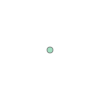

In [29]:
geo_charging_stations_in_trento

## within relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;it's the point inside the area?

In [30]:
geo_charging_stations_in_trento.within(northeast)

True

## contain relation
in our case:<br>&nbsp;&nbsp;&nbsp;&nbsp;does the area contain the point?

In [31]:
northeast.contains(geo_charging_stations_in_trento)

True

we can iterate the operation for each point

_very slow!_

.. so we work with an only one point

In [32]:
charging_stations_northeast = geo_charging_stations[geo_charging_stations.within(northeast)]
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [33]:
charging_stations_northeast.shape

(14615, 16)

In [34]:
charging_stations_northeast.province.unique()

array(['Venezia', 'Trento', 'Modena', 'Bologna', 'Treviso',
       'Forlì-Cesena', 'Parma', 'Rimini', 'Padova', 'Udine', 'Bolzano',
       'Pordenone', "Reggio nell'Emilia", 'Vicenza', 'Piacenza', 'Verona',
       'Belluno', 'Trieste', 'Gorizia', 'Ravenna', 'Ferrara', 'Rovigo',
       'Padua', 'Venice', 'Reggio Emilia', 'Forlì', 'Plaisance', 'Bozen'],
      dtype=object)

.. **Plaisance** isn't a province of the North-East Italy<br/>
https://en.wikipedia.org/wiki/Plaisance,_Gers


In [35]:
charging_stations_northeast[charging_stations_northeast.province == 'Plaisance']

evse_id country_code   province municipality  address  zipcode  \
24475    24467          ITA  Plaisance     Morfasso  SP14, 9  29020.0   
36721    36712          ITA  Plaisance     Morfasso  SP14, 9  29020.0   

        latitude  longitude  status parking_type connector_id  power  \
24475  44.757584    9.69954  Attivo                         2  Quick   
36721  44.757584    9.69954  Attivo                         1  Quick   

      parking_restrictions nearby_services opening_hours  \
24475                                        Aperto 24/7   
36721                                        Aperto 24/7   

                       geometry  
24475  POINT (9.69954 44.75758)  
36721  POINT (9.69954 44.75758)

In [36]:
macroregions_high_details = gpd.read_file("https://github.com/napo/geospatialcourse2025/raw/refs/heads/main/data/macroregions_high_details.zip")

In [37]:
northeast_high_details = macroregions_high_details.to_crs(epsg=4326).geometry[1]

In [38]:
charging_stations_northeast = geo_charging_stations[geo_charging_stations.within(northeast_high_details)]


In [39]:
charging_stations_northeast.province.unique()

array(['Venezia', 'Trento', 'Modena', 'Bologna', 'Treviso',
       'Forlì-Cesena', 'Parma', 'Rimini', 'Padova', 'Udine', 'Bolzano',
       'Pordenone', "Reggio nell'Emilia", 'Vicenza', 'Piacenza', 'Verona',
       'Belluno', 'Trieste', 'Gorizia', 'Ravenna', 'Ferrara', 'Rovigo',
       'Padua', 'Venice', 'Reggio Emilia', 'Forlì', 'Plaisance', 'Bozen'],
      dtype=object)

In [40]:
plaisance_charger = geo_charging_stations[geo_charging_stations.province == 'Plaisance']

In [41]:
plaisance_charger

evse_id country_code   province municipality  address  zipcode  \
24475    24467          ITA  Plaisance     Morfasso  SP14, 9  29020.0   
36721    36712          ITA  Plaisance     Morfasso  SP14, 9  29020.0   

        latitude  longitude  status parking_type connector_id  power  \
24475  44.757584    9.69954  Attivo                         2  Quick   
36721  44.757584    9.69954  Attivo                         1  Quick   

      parking_restrictions nearby_services opening_hours  \
24475                                        Aperto 24/7   
36721                                        Aperto 24/7   

                       geometry  
24475  POINT (9.69954 44.75758)  
36721  POINT (9.69954 44.75758)

In [42]:
point_plaisance = plaisance_charger.head(1).geometry.values[0]

In [43]:
municipalities[municipalities.to_crs(epsg=4326).contains(point_plaisance)]

COD_RIP  COD_REG  COD_PROV  COD_CM  COD_UTS  PRO_COM PRO_COM_T  \
3676        2        8        33       0       33    33028    033028   

        COMUNE COMUNE_A  CC_UTS  \
3676  Morfasso     None       0   

                                               geometry  
3676  MULTIPOLYGON (((556942.426 4959200.182, 556993...

In [44]:
provinces[provinces.COD_PROV == 33]

COD_RIP  COD_REG  COD_PROV  COD_CM  COD_UTS  DEN_PROV DEN_CM   DEN_UTS  \
32        2        8        33       0       33  Piacenza      -  Piacenza   

   SIGLA   TIPO_UTS                                           geometry  
32    PC  Provincia  MULTIPOLYGON (((523754.17 4948828.257, 523706....

**Plaisance** is the french name of Piacenza<br/>
https://fr.wikipedia.org/wiki/Plaisance_(Italie)

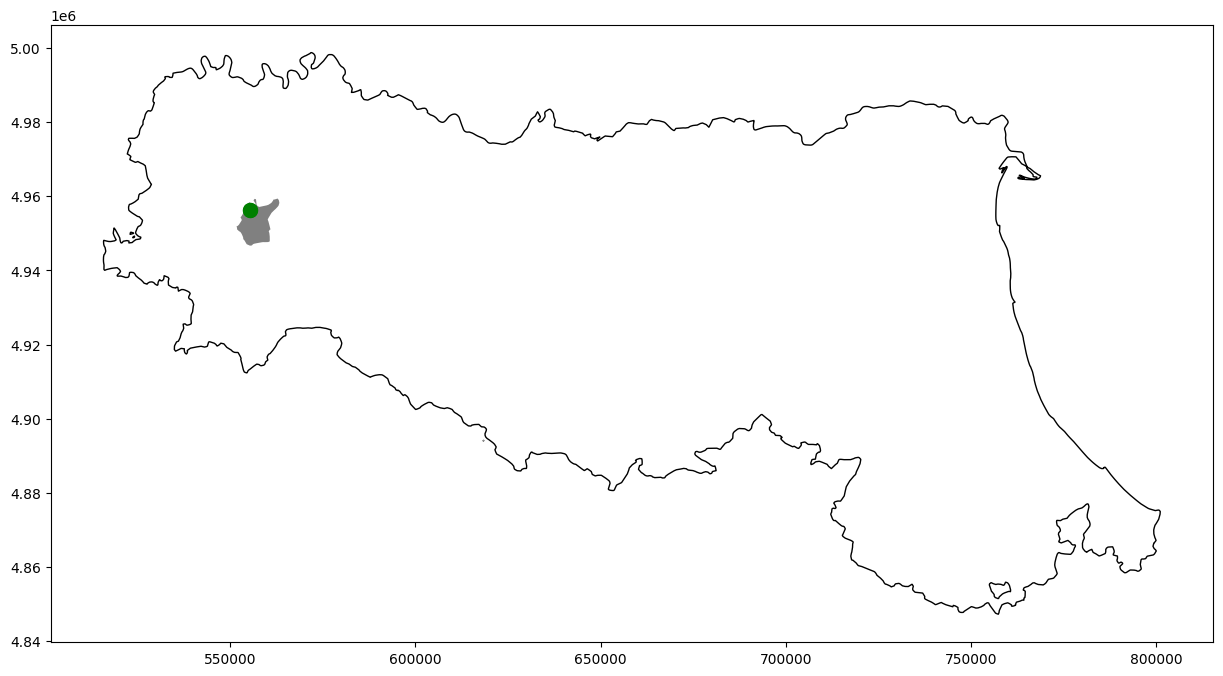

In [45]:
ax = regions[regions.COD_REG==8].plot(edgecolor='black', facecolor='none', figsize=(15, 10))
municipalities[municipalities.COMUNE=="Morfasso"].plot(ax=ax,color="gray")
plaisance_charger.to_crs(regions.crs).plot(ax=ax,color="green",markersize=100)
plt.show()



---


<b>REFERENCE</b>: <br>

Overview of the different functions to check spatial relationships (*spatial predicate functions*):
<ul>
    <li>`equals`</li>
<li>`contains`</li>
<li>`crosses`</li>
<li>`disjoint`</li>
<li>`intersects`</li>
<li>`overlaps`</li>
<li>`touches`</li>
<li>`within`</li>
<li>`covers`</li>
</ul>


See https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships for an overview of those methods.


See https://en.wikipedia.org/wiki/DE-9IM for all details on the semantics of those operations.

# Spatial Joins

You can create a join like the usual [join](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) between pandas dataframe by using a spatial relationship with the function [geopandas.sjoin](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html)

In [46]:
charging_stations_and_macroregions = gpd.sjoin(macroregions.to_crs(epsg=4326),
                          geo_charging_stations, how='inner', predicate='contains', lsuffix='macroregions_', rsuffix='chargingstations')
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.25 µs


In [47]:
charging_stations_and_macroregions.columns

Index(['COD_RIP', 'DEN_RIP', 'geometry', 'index_chargingstations', 'evse_id',
       'country_code', 'province', 'municipality', 'address', 'zipcode',
       'latitude', 'longitude', 'status', 'parking_type', 'connector_id',
       'power', 'parking_restrictions', 'nearby_services', 'opening_hours'],
      dtype='object')

In [48]:
charging_stations_and_macroregions.shape

(62905, 19)

In [49]:
charging_stations_and_macroregions.head(5)

COD_RIP     DEN_RIP                                           geometry  \
0        1  Nord-ovest  MULTIPOLYGON (((9.85139 44.0237, 9.8514 44.023...   
0        1  Nord-ovest  MULTIPOLYGON (((9.85139 44.0237, 9.8514 44.023...   
0        1  Nord-ovest  MULTIPOLYGON (((9.85139 44.0237, 9.8514 44.023...   
0        1  Nord-ovest  MULTIPOLYGON (((9.85139 44.0237, 9.8514 44.023...   
0        1  Nord-ovest  MULTIPOLYGON (((9.85139 44.0237, 9.8514 44.023...   

   index_chargingstations  evse_id country_code   province municipality  \
0                   48705    48682          ITA  La Spezia       Lerici   
0                   10854    10848          ITA  La Spezia       Lerici   
0                   19822    19815          ITA  La Spezia         Luni   
0                   47076    47056          ITA  La Spezia         Luni   
0                    2022     2022          ITA  La Spezia         Luni   

                            address  zipcode   latitude  longitude  status  \
0  Via Fiascherino IIª Traversa, 28  19032.0  44.060370   9.929410  Attivo   
0  Via Fiascherino IIª Traversa, 28  19032.0  44.060370   9.929410  Attivo   
0                  Via Aurelia, 103  19034.0  44.072167  10.021861  Attivo   
0                  Via Aurelia, 103  19034.0  44.072167  10.021861  Attivo   
0                         Via Parma  19034.0  44.075140  10.026419  Attivo   

  parking_type                          connector_id       power  \
0               bea52de8-8347-443f-b636-170740455558       Quick   
0               610e362f-244b-44b4-b01b-a2ebd7b19e36       Quick   
0                                                  2       Quick   
0                                                  1       Quick   
0  PARKING_LOT                                     1  Ultra fast   

  parking_restrictions nearby_services opening_hours  
0                                        Aperto 24/7  
0                                        Aperto 24/7  
0                                        Aperto 24/7  
0                                        Aperto 24/7  
0              PLUGGED                   Aperto 24/7

In [50]:
charging_stations_and_macroregions.geom_type.unique()

array(['MultiPolygon'], dtype=object)

... and now you can investigate the new geodataframe

In [51]:
charging_stations_and_macroregions.groupby(['DEN_RIP']).index_chargingstations.count()

DEN_RIP
Centro        12483
Isole          4924
Nord-est      14615
Nord-ovest    22667
Sud            8216
Name: index_chargingstations, dtype: int64

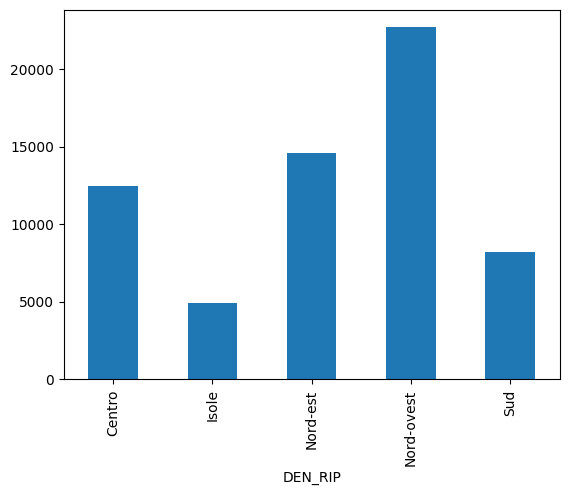

In [52]:
charging_stations_and_macroregions.groupby(['DEN_RIP']).index_chargingstations.count().plot(kind='bar')
plt.show()


<b>SPATIAL JOIN </b>= *transferring attributes from one layer to another based on their spatial relationship*<br/>

Different parts of this operations:
<ul>
    <li>The GeoDataFrame to which we want add information</li>
    <li>The GeoDataFrame that contains the information we want to add</li>
    <li>The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')</li>
    <li>The type of join: left or inner join</li>
</ul>


---
# Spatial operations
GeoPandas provide analysis methods that return new geometric objects (based on shapely)

See [https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods](https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods) for more details.

## buffer
*object.buffer(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0)*

Returns an approximate representation of all points within a given distance of the this geometric object.

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/buffer.png)


In [53]:
charging_station_in_trento_32632 = geo_charging_stations[geo_charging_stations.municipality == 'Trento'].to_crs(32632).geometry.values[0]

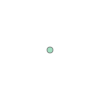

In [54]:
charging_station_in_trento_32632

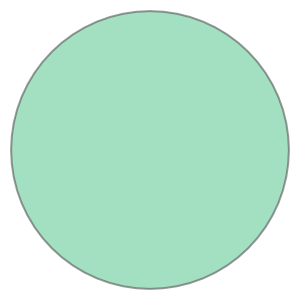

In [55]:
charging_station_in_trento_32632.buffer(9000) # a circle with a ray of 9000 meters

due to the algorithm with which the buffer is built, as the value increases, from whatever geometry one starts, the result will take on more and more the shape of a circumference.


<img src="https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/buffer.gif" width="450px"/>

## simplify

*object.simplify(tolerance, preserve_topology=True)*

    Returns a simplified representation of the geometric object.


In [56]:
northeast_geometry = macroregions[macroregions.COD_RIP==2].geometry.values[0]

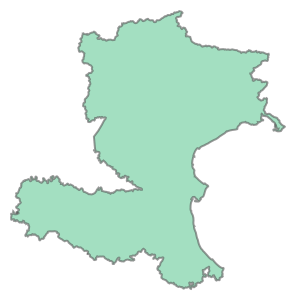

In [57]:
northeast_geometry

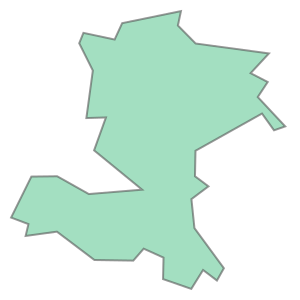

In [58]:
northeast_geometry.simplify(10000,preserve_topology=False)

## Es. symmetric_difference
*object.symmetric_difference(other)*

    Returns a representation of the points in this object not in the other geometric object, and the points in the other not in this geometric object.


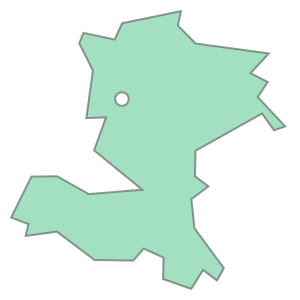

In [59]:
northeast_geometry.simplify(10000,preserve_topology=False).symmetric_difference(charging_station_in_trento_32632.buffer(9000))

<b>REMEMBER:</b>

GeoPandas (and Shapely for the individual objects) provides a whole lot of basic methods to analyse the geospatial data (distance, length, centroid, boundary, convex_hull, simplify, transform, ....), much more than the few that we can touch in this tutorial.
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="https://geopandas.readthedocs.io/en/latest/docs/reference.html">https://geopandas.readthedocs.io/en/latest/docs/reference.html</a></li>
    </ul>



---
# Clip

Extracts input features that overlay the clip features.

![](https://desktop.arcgis.com/en/arcmap/10.3/tools/analysis-toolbox/GUID-6D3322A8-57EA-4D24-9FFE-2A9E7C6B29EC-web.gif)

```python
 geopandas.clip(gdf, mask, keep_geom_type=False)
 ```
 *gdf* = geodataframe<Br/>
 *mask* = polygon

In [60]:
municipalities_inside_circle = municipalities.clip(charging_station_in_trento_32632.buffer(9000))

In [61]:
municipalities_inside_circle.COMUNE.unique()

array(['Cimone', 'Calliano', 'Besenello', 'Aldeno',
       'Altopiano della Vigolana', 'Cavedine', 'Garniga Terme',
       'Madruzzo', 'Vallelaghi', 'Pergine Valsugana', 'Trento',
       'Civezzano', 'Fornace', 'Baselga di Pinè', 'Albiano', 'Lavis'],
      dtype=object)

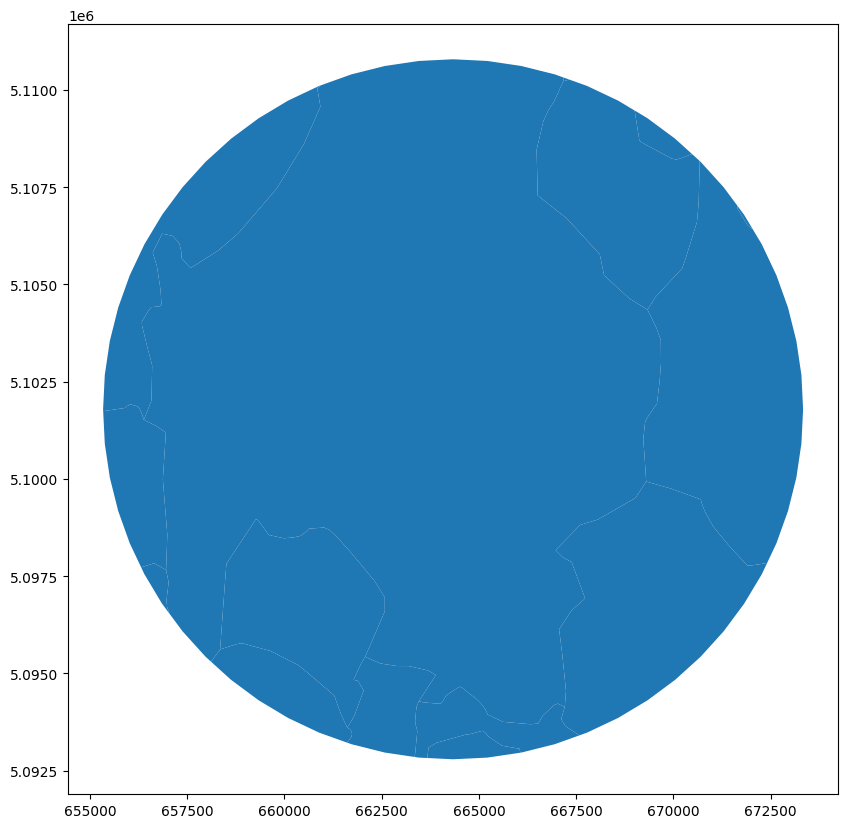

In [62]:
municipalities_inside_circle.plot(figsize=(10,10))
plt.show()

---
# Aggregation with dissolve

Spatial data are often more granular than we need. For example, we have the data of the macro-regions but we don't have a geometry with the border of Italy.

If we have a columns to operate a *groupby* we can solve it but to create the geometry we need the function *dissolve*.



In [63]:
macroregions['nation']='italy'

In [64]:
macroregions

COD_RIP     DEN_RIP                                           geometry  \
0        1  Nord-ovest  MULTIPOLYGON (((568231.969 4874857.994, 568233...   
1        2    Nord-est  MULTIPOLYGON (((618335.21 4893983.16, 618329.9...   
2        3      Centro  MULTIPOLYGON (((876027.96 4525207.198, 876222....   
3        4         Sud  MULTIPOLYGON (((1083304.797 4416671.21, 108333...   
4        5       Isole  MULTIPOLYGON (((822779.053 3935557.494, 822909...   

  nation  
0  italy  
1  italy  
2  italy  
3  italy  
4  italy

In [65]:
italy = macroregions[['nation', 'geometry']]

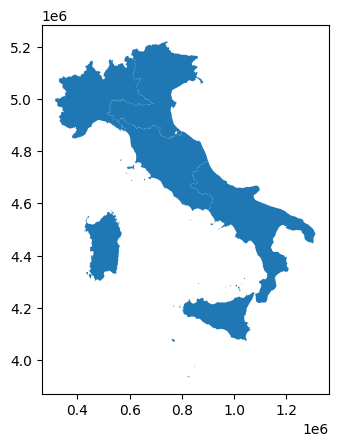

In [66]:
italy.plot()
plt.show()

In [67]:

italy = italy.to_crs(epsg=4326).dissolve(by='nation')
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [68]:
italy

geometry
nation                                                   
italy   MULTIPOLYGON (((8.41196 38.86038, 8.41113 38.8...

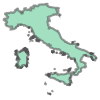

In [69]:
italy.geometry[0]

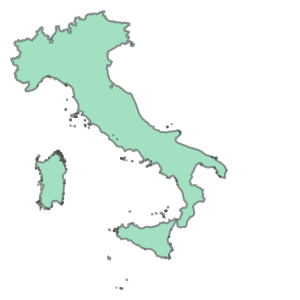

In [70]:
italy.to_crs(epsg=32632).geometry[0]

<b>REMEMBER:</b>

dissolve can be thought of as doing three things: (a) it **dissolves** all the geometries within a given group together into a single geometric feature (using the *unary_union* method), and (b) it **aggregates** all the rows of data in a group using *groupby.aggregate()*, and (c) it **combines** those two results.
    
<ul>
<li>An overview of all methods provided by GeoPandas can be found here: <a href="http://geopandas.org/aggregation_with_dissolve.html">http://geopandas.org/aggregation_with_dissolve.html</a></li>
 </ul>

---
# Overlay

Spatial overlays allow you to compare two GeoDataFrames containing polygon or multipolygon geometries and create a new GeoDataFrame with the new geometries representing the spatial combination and merged properties. This allows you to answer questions like

    What are the demographics of the census tracts within 90km from a point?

The basic idea is demonstrated by the graphic below but keep in mind that overlays operate at the dataframe level, not on individual geometries, and the properties from both are retained

![](https://docs.qgis.org/testing/en/_images/overlay_operations.png)

source: https://geopandas.org/gallery/overlays.html


In [71]:
macroregion_gdf = macroregions[macroregions.COD_RIP==2].to_crs(epsg=32632)

In [72]:
overlay = italy.to_crs(epsg=32632).overlay(macroregion_gdf, how="difference")

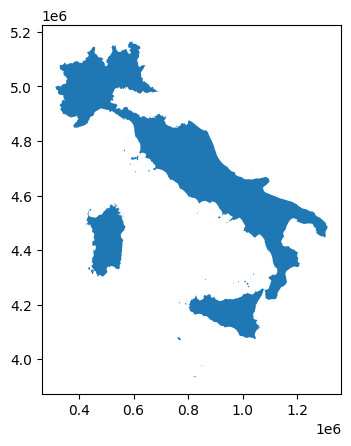

In [73]:
overlay.plot()
plt.show()

---
# Exercise

1 - create the geodataframe of the [libraries](https://opendata.anagrafe.iccu.sbn.it/territorio.zip) of Italy (data from the italian [Ministry of Culture](https://anagrafe.iccu.sbn.it/it/open-data/)) and count the total of the libraries for each muncipality of Trentino Alto Adige

2 - identify the difference of municipalities in Trentino in the year [2016](https://github.com/napo/geospatialcourse2025/raw/refs/heads/main/data/municipalities_trentino_2016.parquet) with the year [2021](https://github.com/napo/geospatial_unitn_2025/raw/refs/heads/main/data/municipalities_trentino_2021.parquet)
  - identify which municipalities are created from aggregation to others
  - find the new municipality with the largest extension in Trentino and show all the italian municipalities with bordering it
  - create the macroarea of all the municipalities bordering with it
  - for each library in the macro-area, calculate how many electric charging stations have been within a 500m radius
  
3 - create a polygon that contains all the charging stations inside the area
  - identify all the libraries in this area which are within 2km of each other
  - save the polygon in geopackage with the attribute "description" with the name of the library

4 - create the polygon of the Island of Elba from the layer of municipalities with functions of overlay